# Not So Random Forest
### A step-by-step guide to train and run inference on images

This notebook has three parts. In Part A, I detail training the object detector and species classifier models. In Part B, I give instructions for running inference on sample images. In Part C, I visualize some inference results. The code assumes that the user is running this notebook from the top level of the not-so-random-forest directory. 

## Part A: Training

### 1. Object detector: RetinaNet

#### 1a. Installing RetinaNet

It is necessary to install RetinaNet before training on tree annotations. RetinaNet can be installed by entering the following command at the command line (without the starting **!**):

In [72]:
!pip install models/training/retinanet/ --user

Processing ./models/training/retinanet
  Running setup.py bdist_wheel for keras-retinanet ... done
  Stored in directory: /private/var/folders/r2/m0bvt3r11cg5mpfz3jmrs4f80000gp/T/pip-ephem-wheel-cache-panjof9f/wheels/f3/46/6d/6387a80e9e5782e28a3dde9fb43e5ca931baaab2f90576e9c3
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.3.1
    Uninstalling keras-retinanet-0.3.1:
      Successfully uninstalled keras-retinanet-0.3.1
  The scripts retinanet-convert-model, retinanet-debug, retinanet-evaluate and retinanet-train are installed in '/Users/vyettella/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


#### 1b. Training RetinaNet
I trained RetinaNet on tree annotations derived from 300 street view images. Training requires not only images but also bounding box annotations of trees. These annotations along with the corresponding street view images may be downloaded as a .zip file from [dropbox](https://www.dropbox.com/s/6p4n2bq1jkzzxnb/retinanet_images.zip?dl=0). Assuming that the contents of the zip file have been extracted to `data/detection/`, RetinaNet can be trained from the command line using the following command (without the starting **!**):

In [73]:
!./models/training/retinanet/keras_retinanet/bin/train.py \
--epochs 1 --steps 1 \
--snapshot-path ./models/training/saved_models/tree_detectors \
csv ./data/detection/tree_annotations_300_athens.csv \
./data/detection/mappings_300.csv

Using TensorFlow backend.
2018-07-08 17:24:16.715425: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Creating model, this may take a second...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
_________________________________________________________________

res4d (Add)                     (None, None, None, 1 0           bn4d_branch2c[0][0]              
                                                                 res4c_relu[0][0]                 
__________________________________________________________________________________________________
res4d_relu (Activation)         (None, None, None, 1 0           res4d[0][0]                      
__________________________________________________________________________________________________
res4e_branch2a (Conv2D)         (None, None, None, 2 262144      res4d_relu[0][0]                 
__________________________________________________________________________________________________
bn4e_branch2a (BatchNormalizati (None, None, None, 2 1024        res4e_branch2a[0][0]             
__________________________________________________________________________________________________
res4e_branch2a_relu (Activation (None, None, None, 2 0           bn4e_branch2a[0][0]              
__________

/Users/vyettella/anaconda3/envs/insight/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
Epoch 1/1
1/1 [==============================] - 16s 16s/step - loss: 3.9996 - regression_loss: 2.8645 - classification_loss: 1.1351

Epoch 00001: saving model to ./models/training/saved_models/tree_detectors/resnet50_csv_01.h5


While training, RetinaNet saves model snapshots after each epoch in `.h5` format to the path specified by `--snapshot-path`. Note that I set `--epochs` and `--steps` to `1` in the example above for ease of illustration. For actual training, I set `--epochs` to `50` and `--steps` to `1000`. 


The model created by the training procedure is not fit for inference just yet. It needs to be converted into a form that is useful for inference. Instructions can be found [here](https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model). A model that I trained and converted to inference form can be downloaded from [dropbox](https://www.dropbox.com/s/x8nqy3iuhma840o/resnet50_csv_50_epochs_inference.h5?dl=0).

### 2. Species Classifier

`species_classifier_cnn.py` located in `models/training` is used for training species classifiers. The user can choose from two backbone options: `ResNet50`, `InceptionV3`. As a third option, I have added functionality to leverage custom backbones: write any custom backbones under the `custom_cnn()` function in `species_classifier_cnn.py`. 

Species images that I scraped from google images can be downloaded from [dropbox](https://www.dropbox.com/s/uchjflyy1pmobmy/species_images.zip?dl=0).

Assuming that the species images are placed in `data/classification`, training can be initiated by the following command (without the starting **!**):

In [7]:
!python ./models/training/species_classifier_cnn.py \
--epochs 1 --batch_size 10 --freeze_backbone \
--image_dir ./data/classification/ \
--save_dir ./models/training/saved_models/species_classifiers/ --classifier Custom

Using TensorFlow backend.
Found 1562 images belonging to 18 classes.
Found 378 images belonging to 18 classes.
All base layers have been frozen.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0       

A trained binary species classifier that is able to distinguish date palm trees from other types of trees with accuracy ~90% can be downloaded from [dropbox](https://www.dropbox.com/s/cnsskd01bj0zenk/date_palm_classifier.h5?dl=0). I am currently working on improving the accuracy of a classifer that is able to classify 18 tree species. I will include a link to the trained model in this notebook once the work is completed.

# Part B: Inference

I include the script `inference.py` in `./models/inference/` to facilitate inference on street view images. The script is run from the command line and takes as inputs, the path to the folder containing images of interest, path to the object detector model and path to the species classifier model. As an optional argument, the script also takes a score threshold value that is used for [non-max suppression](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH). 

Inference results for each image are stored in a dictionary with the following keys:  

`boxes` : numpy array with geometric coordinates of bounding boxes  
`species_probabilities` : probability scores for each species  
`score threshold` : score threshold as defined above  

The dictionary is pickled and saved to the same folder as the images. The sample images I am running inference on for the purpose of illustration can be downloaded from [dropbox](https://www.dropbox.com/s/atevcc0dwdgnt8v/sample_images.zip?dl=0). 

Assuming that the detector model is saved to `models/training/saved_models/tree_detectors`, the classifier model to `models/training/saved_models/species_classifiers` and sample images to `models/inference/sample_images`, inference can be initiated with the following command (without the starting **!**):  



In [64]:
!python models/inference/inference.py --image_dir models/inference/sample_images/ \
--detector_path models/training/saved_models/tree_detectors/resnet50_csv_50_epochs_inference.h5 \
--classifier_path models/training/saved_models/species_classifiers/date_palm_classifier.h5

Using TensorFlow backend.
2018-07-08 17:16:47.677779: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
/Users/vyettella/anaconda3/envs/insight/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
models/inference/sample_images/sample_3.jpg
detection time:  3.9759678840637207
classification time:  0.19669413566589355
models/inference/sample_images/sample_2.jpg
detection time:  3.2450051307678223
classification time:  0.08792495727539062
models/inference/sample_images/sample_1.jpg
detection time:  3.4331061840057373
classification time:  0.05828714370727539


# Part C: Visualization

Here I visualize inference results (see previous section for instructions to run inference) for some sample images from the city of Athens using a binary species classifier. Species probability closer to 0 indicates that the tree is more likely to be a date palm tree that not, and vice-versa for a species probability closer to 1. The visualization code can be found in `plotters.py` within the `utils` folder.

In [67]:
# import custom modules
from utils import plotters
import importlib
importlib.reload(plotters)

<module 'utils.plotters' from '/Users/vyettella/not-so-random-forest/utils/plotters.py'>

Species probabilities: 
[[1.]
 [0.]
 [1.]]


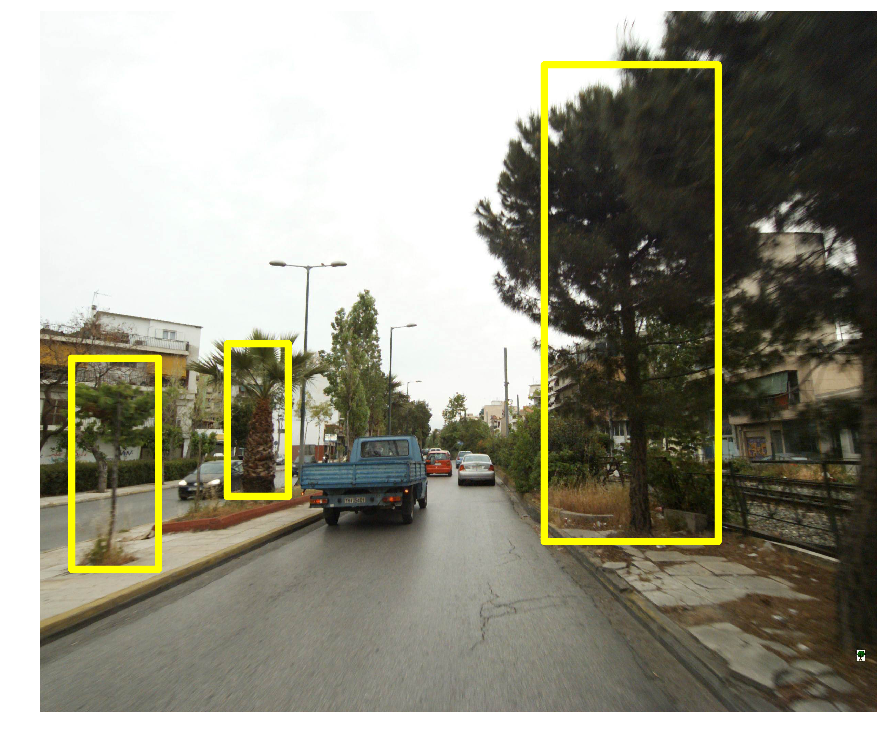

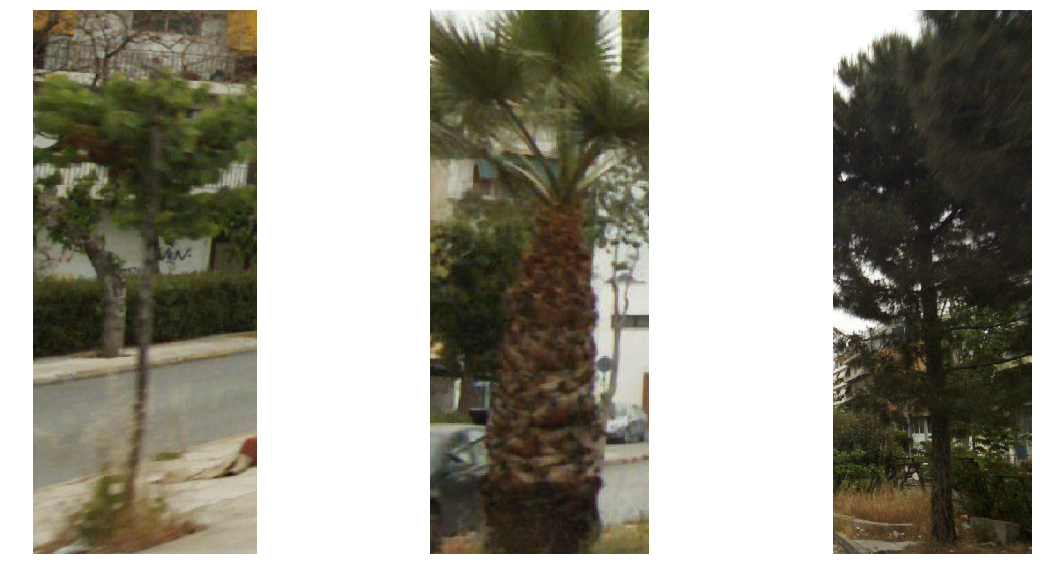

In [71]:
# sample image 1
image_path = 'models/inference/sample_images/sample_1.jpg'
plotters.visualize_inference(image_path)

Species probabilities: 
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


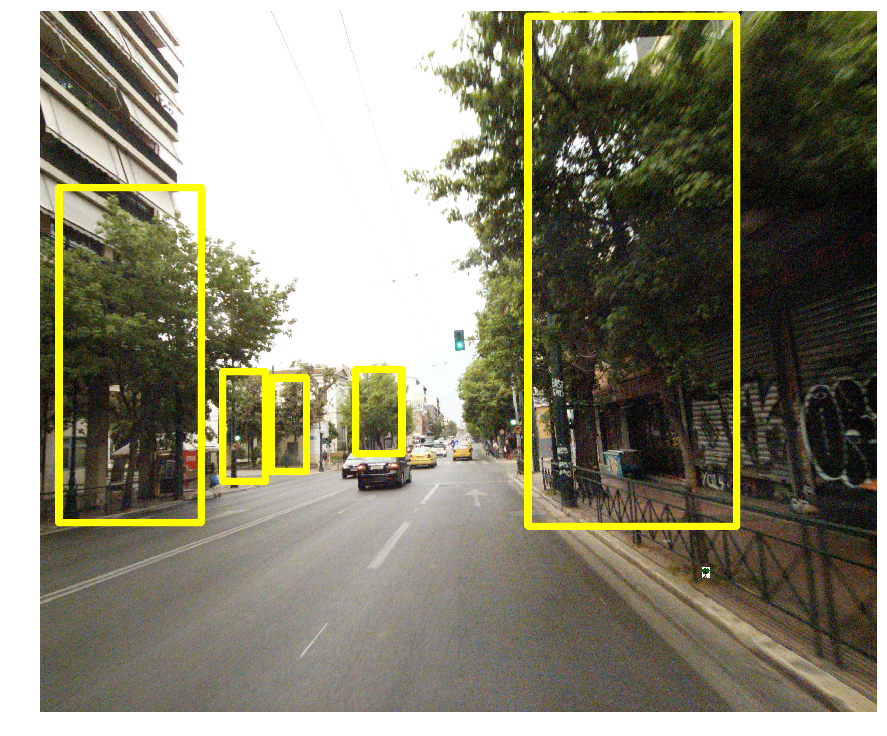

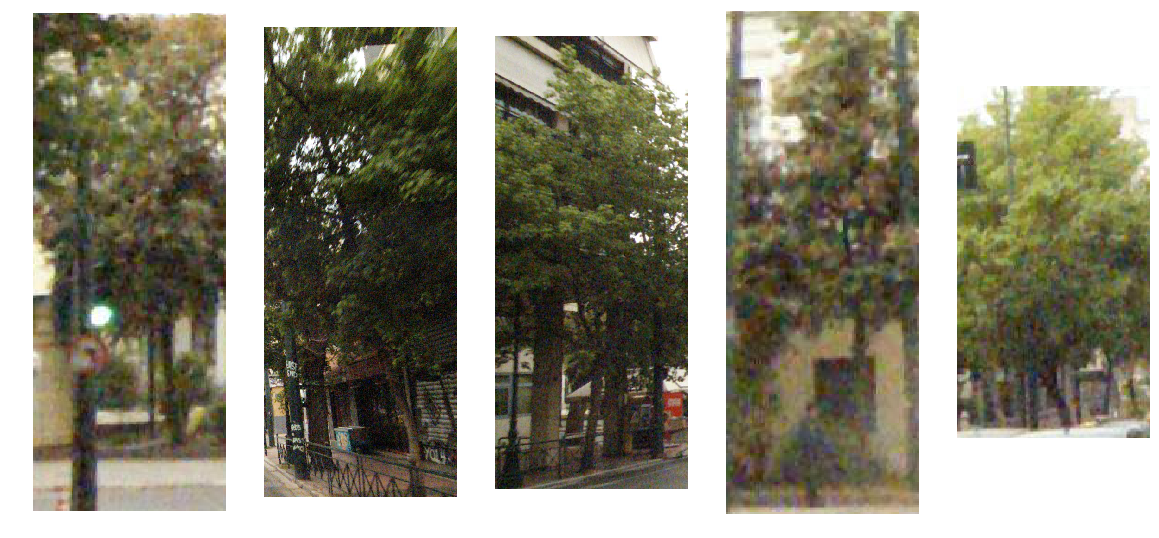

In [70]:
# sample image 2
image_path = 'models/inference/sample_images/sample_2.jpg'
plotters.visualize_inference(image_path)

Species probabilities: 
[[1.]
 [0.]
 [1.]
 [1.]]


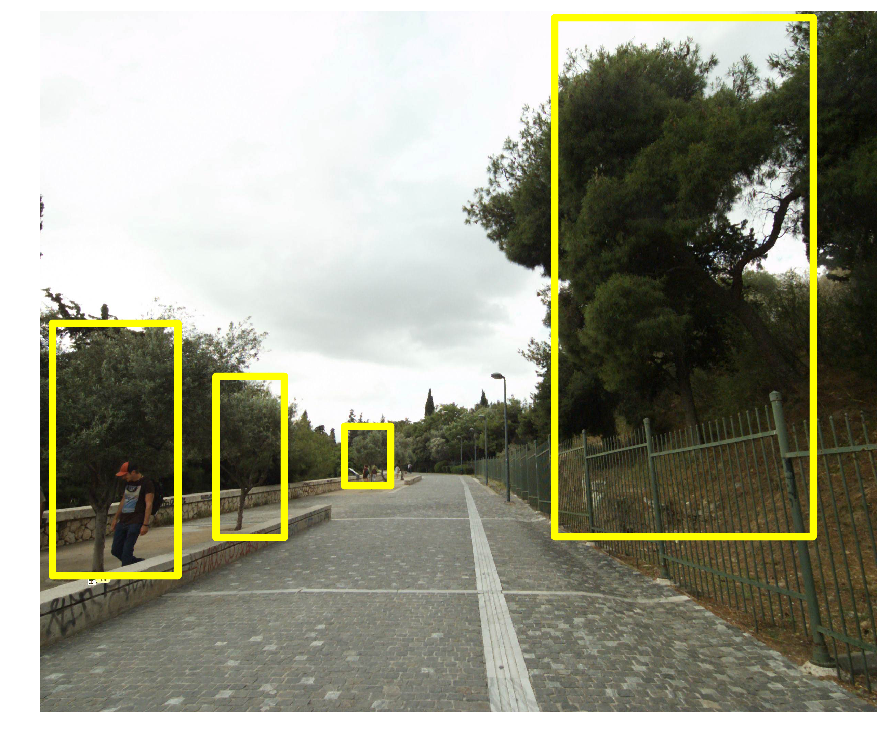

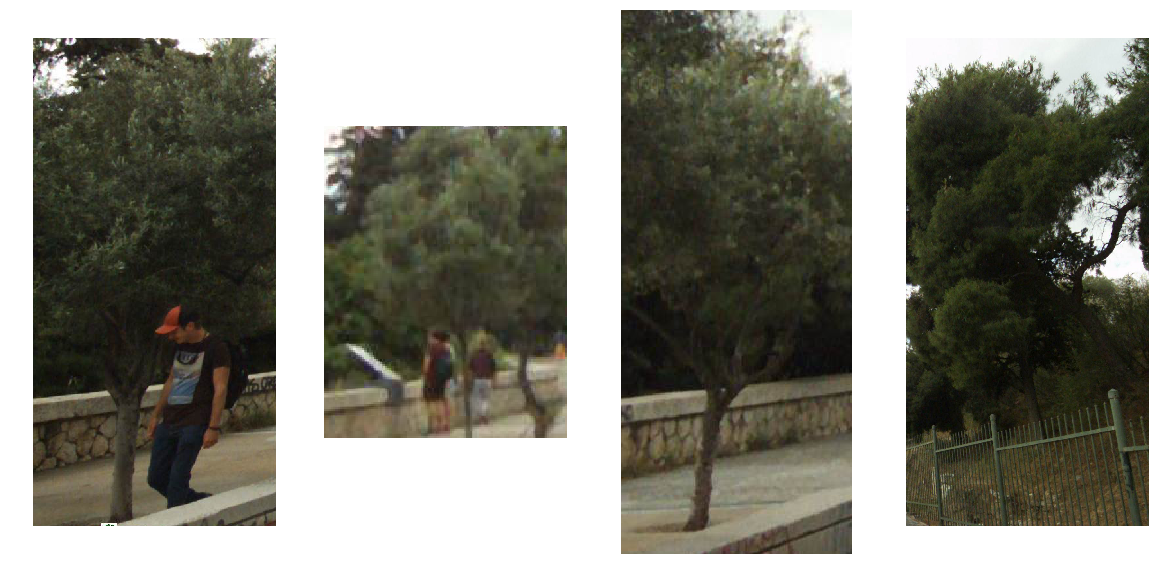

In [61]:
# sample image 3
image_path = 'models/inference/sample_images/sample_3.jpg'
plotters.visualize_inference(image_path)